In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score as r2, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

from matplotlib import rcParams
# matplotlib.rcParams.update({'font.size': 10})
pd.options.display.max_columns = 30

In [2]:
import warnings
warnings.filterwarnings('ignore')

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [3]:
train = pd.read_csv('train.csv')
train.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524


In [4]:
test = pd.read_csv('test.csv')
test.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B


In [5]:
train.shape

(10000, 20)

In [6]:
test.shape

(5000, 19)

#### Приведение типов данных

In [7]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
test.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [9]:
train['Id'].dtype

dtype('int64')

In [10]:
test['Id'].dtype

dtype('int64')

In [11]:
train['Id'] = train['Id'].astype(str)
train['Id'].dtype

dtype('O')

In [12]:
test['Id'] = test['Id'].astype(str)
test['Id'].dtype

dtype('O')

In [13]:
train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [14]:
test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


Что не нравится и хотелось бы скорректировать:

1. приведение категориальных признаков Ecology_2, Ecology_3, Shops_2 в бинарные
* некорректные значения HouseYear в train
* недостаток данных Healthcare_1
* недостаток данных LifeSquare
* max KitchenSquare выглядит слишком большим в обоих датасетах
* max LifeSquare выглядит слишком большим в train
* min LifeSquare выглядит слишком малым в обоих датасетах

Что касается площадей - в моем понимании Square > KitchenSquare + LifeSquare. Исходя из этой логики в дальнейшем будем пытаться скорректировать значения в датасетах

#### 1. Приведение категориальных признаков Ecology_2, Ecology_3, Shops_2 в бинарные
Проверим количество возможных значений в категориальных признаках Ecology_2, Ecology_3, Shops_2 датасета train:

In [15]:
print(train['Ecology_2'].value_counts()) 
print(train['Ecology_3'].value_counts()) 
print(train['Shops_2'].value_counts())

B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


Т.к. каждый из категориальных признаков Ecology_2, Ecology_3, Shops_2 содержит только два варианта значений (A или B), то мы можем оставить только одно из них, которое будет соответствовать '1', а '0' будет соответствовать другому варианту. Заметим также, что в этих признаках нет пропусков.

In [16]:
train = pd.concat([train, 
                   pd.get_dummies(pd.DataFrame({'Ecology_2':train['Ecology_2'], 
                                                'Ecology_3':train['Ecology_3'], 
                                                'Shops_2':train['Shops_2']}), 
                                  prefix=['Ecol_2', 'Ecol_3', 'Shops_2'], 
                                  prefix_sep='_', 
                                  drop_first=True, 
                                  dtype='int64')
                  ], axis=1)
train.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1, inplace=True)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecol_2_B,Ecol_3_B,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730,1,1,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063,1,1,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524,1,1,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217,1,1,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644,1,1,1


In [17]:
train.shape

(10000, 20)

Аналогично проверим количество возможных значений в категориальных признаках Ecology_2, Ecology_3, Shops_2 датасета test, а также убедимся в отсутствии пропусков, и проведем те же манипуляции над датасетом для приведения названных признаков в бинарные:

In [18]:
print(test['Ecology_2'].value_counts()) 
print(test['Ecology_3'].value_counts()) 
print(test['Shops_2'].value_counts())

B    4952
A      48
Name: Ecology_2, dtype: int64
B    4851
A     149
Name: Ecology_3, dtype: int64
B    4588
A     412
Name: Shops_2, dtype: int64


In [19]:
test = pd.concat([test, 
                   pd.get_dummies(pd.DataFrame({'Ecology_2':test['Ecology_2'], 
                                                'Ecology_3':test['Ecology_3'], 
                                                'Shops_2':test['Shops_2']}), 
                                  prefix=['Ecol_2', 'Ecol_3', 'Shops_2'], 
                                  prefix_sep='_', 
                                  drop_first=True, 
                                  dtype='int64')
                  ], axis=1)
test.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1, inplace=True)
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecol_2_B,Ecol_3_B,Shops_2_B
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,11,2748,1,NaN,0,0,1,1,1
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,6,1437,3,NaN,0,2,1,1,1
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,30,7538,87,4702.0,5,5,1,1,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,23,4583,3,NaN,3,3,1,1,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,2,629,1,NaN,0,0,1,1,0


In [20]:
test.shape

(5000, 19)

#### 2. Исправим значение HouseYear в датасете train

In [21]:
train.loc[train['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecol_2_B,Ecol_3_B,Shops_2_B
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,30,6141,10,262.0,3,6,254084.534396,1,1,1
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,25,4756,16,2857.0,5,8,243028.603096,1,1,1


Из предыдущего вывода видно 2 выброса c DistrictId 109 и 147. Т.к. это всего два значения, они не должны оказать сильного влияния на обучение, но, тем не менее являются выбросами. Предположу замену HouseYear в первом случае на 2011, а во втором на 1968.

In [22]:
train.loc[(train['HouseYear'] == 20052011), 'HouseYear'] = 2011
train.loc[(train['HouseYear'] == 4968), 'HouseYear'] = 1968
pd.concat([train.loc[1497:1497,:], train.loc[4189:4189,:]], axis=0)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecol_2_B,Ecol_3_B,Shops_2_B
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,2011,0.136330,30,6141,10,262.0,3,6,254084.534396,1,1,1
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,1968,0.319809,25,4756,16,2857.0,5,8,243028.603096,1,1,1


#### 3. Заполним недостающие данные Healthcare_1

In [23]:
# рассмотрим таблицу корреляций признака Healthcare_1
train.corr()[['Healthcare_1']]

,Healthcare_1
DistrictId,0.304335
Rooms,0.042857
Square,-0.039748
LifeSquare,-0.026867
KitchenSquare,0.009472
Floor,-0.138294
HouseFloor,-0.143973
HouseYear,-0.205527
Ecology_1,-0.043547
Social_1,0.077133


Исходя из предыдущей таблицы и сведений о признаках предположу, что признак Healthcare_1 зависит от (в порядке убывания):
 - DistrictId
 - Social_1
 - Social_2
 - Social_3
 - Helthcare_2

Заполняем пропуски Healthcare_1

In [24]:
def ident_model(train_df):
    model_1 = RandomForestClassifier(max_depth=15)
    train_ = train_df[train_df['Healthcare_1'].isna() == False][['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2','Healthcare_1']]
    tr, tst = train_test_split(train_, test_size = 0.15, random_state = 29)
    model_1.fit(tr.drop('Healthcare_1', axis = 1), tr['Healthcare_1'])
    pred = model_1.predict(tst.drop('Healthcare_1', axis = 1))
    print(accuracy_score(tst['Healthcare_1'], pred))
    test_ = train_df[train_df['Healthcare_1'].isna()][['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2','Healthcare_1']]
    model_1.fit(train_.drop('Healthcare_1', axis = 1), train_['Healthcare_1'])
    pred = model_1.predict(test_.drop('Healthcare_1', axis = 1))
    return model_1


def fill_H1(model_1, train_df):
    test_ = train_df[train_df['Healthcare_1'].isna()][['DistrictId', 'Social_1','Social_2', 'Social_3', 'Helthcare_2','Healthcare_1']]
    pred = model_1.predict(test_.drop('Healthcare_1', axis = 1))
    return pred

In [25]:
model_1 = ident_model(train)
pred = fill_H1(model_1, train)

0.998719590268886


In [26]:
# заполняем пропуски в тренировочном датасете
train.loc[train['Healthcare_1'].isna(), 'Healthcare_1'] = pred
train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Price               0
Ecol_2_B            0
Ecol_3_B            0
Shops_2_B           0
dtype: int64

In [27]:
# заполняем тестовый датасет
predict_test_H1 = fill_H1(model_1, test)
test.loc[test['Healthcare_1'].isna(), 'Healthcare_1'] = predict_test_H1
test.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Ecol_2_B            0
Ecol_3_B            0
Shops_2_B           0
dtype: int64

#### 4. Заполним недостающие данные LifeSquare

In [28]:
# заполняем LifeSquare как (Square - KitchenSquare) * (медиану отношения LifeSquare/(Square - KitchenSquare) для Square > LifeSquare
def fill_LifeSquare(train_df):
    train_df.loc[(train_df['Square'] < train_df['LifeSquare']) | (train_df['LifeSquare'].isna()), 'LifeSquare'] = \
    (train_df.loc[(train_df['Square'] < train_df['LifeSquare']) | (train_df['LifeSquare'].isna()), 'Square'] - \
    train_df.loc[(train_df['Square'] < train_df['LifeSquare']) | (train_df['LifeSquare'].isna()), 'KitchenSquare']) * \
    (train_df.loc[(train_df['Square'] > train_df['LifeSquare']), 'LifeSquare'] / \
    (train_df.loc[(train_df['Square'] > train_df['LifeSquare']), 'Square'] - \
    train_df.loc[(train_df['Square'] > train_df['LifeSquare']), 'KitchenSquare'])).median()
    return train_df

In [29]:
# заполняем пропуски в тренировочном датасете
train = fill_LifeSquare(train)
train.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Price            0
Ecol_2_B         0
Ecol_3_B         0
Shops_2_B        0
dtype: int64

In [30]:
# аналогично для тестового датасета
test = fill_LifeSquare(test)
test.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Ecol_2_B         0
Ecol_3_B         0
Shops_2_B        0
dtype: int64

In [31]:
# заменяем HouseFloor
def fill_HouseFloor(df):
    df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor'] = df.loc[df['Floor'] > df['HouseFloor'], 'Floor']
    return df

train = fill_HouseFloor(train)
test = fill_HouseFloor(test)

In [32]:
#заполняем комнаты
def fill_rooms(df):
    # df.loc[(df['Rooms'] > 5) | (df['Rooms'] == 0), 'Rooms'] = 5
    df.loc[(df['Rooms'] > 5), 'Rooms'] = 5
    df.loc[(df['Rooms'] == 0), 'Rooms'] = 1
    return df

train = fill_rooms(train)
test = fill_rooms(test)

#### Создаем новый признак, средней цены на кв. метр по району

#### 5. Прогнозирование

### Кросс-валидация

### Кластеризация: k-means и последующее выделение 3-х кластеров

In [33]:
from sklearn.cluster import KMeans

In [34]:
def display_clusters_distribution(unique_labels, labels_counts):
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

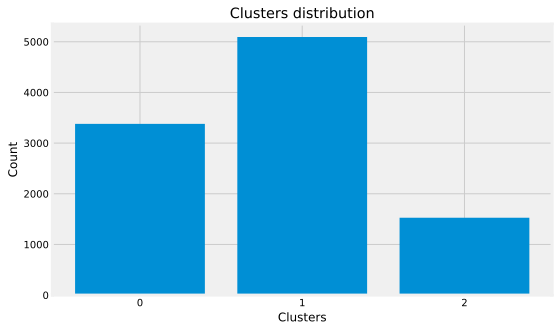

In [35]:
kmeans_3 = KMeans(n_clusters=3, random_state=29)
labels_clast_3 = kmeans_3.fit_predict(train.drop(['Id', 'Price'], axis = 1))
labels_clast_3 = pd.Series(labels_clast_3, name='clusters_3')

unique, counts = np.unique(labels_clast_3, return_counts=True)
display_clusters_distribution(unique, counts)

### Добавление новых признаков

In [36]:
train_ext = pd.concat([train, labels_clast_3], axis=1)
train_ext.sort_values(by=['clusters_3', 'Id'], ascending=True, inplace=True)
train_ext

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecol_2_B,Ecol_3_B,Shops_2_B,clusters_3
2684,10,6,3.0,75.888156,53.580532,1.0,11,17.0,2014,0.243205,5,1564,0,540.0,0,0,218500.747041,1,1,1,0
5374,10015,23,1.0,45.990991,44.179263,1.0,19,25.0,1977,0.075779,6,1437,3,1547.0,0,2,111787.079159,1,1,1,0
1441,10018,1,2.0,67.825862,66.368200,10.0,3,17.0,2015,0.007122,1,264,0,35.0,0,1,228782.780126,1,1,1,0
9630,10021,27,1.0,41.755282,29.159347,1.0,13,20.0,2014,0.211401,9,1892,0,370.0,0,1,94667.059626,1,1,1,0
3908,10030,27,1.0,49.486734,19.903843,1.0,15,17.0,2016,0.017647,2,469,0,0.0,0,0,140042.607407,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5949,9926,149,1.0,42.821584,41.002360,8.0,10,10.0,2002,0.041116,53,14892,4,1970.0,1,4,161577.299862,1,1,1,2
755,9927,99,1.0,36.376217,25.433332,7.0,7,12.0,1974,0.033494,66,10573,1,1322.0,3,8,152679.885430,1,1,1,2
6766,9937,25,1.0,38.957278,18.348159,8.0,2,17.0,1999,0.069753,53,13670,4,1970.0,1,11,165261.710920,1,1,1,2
4546,999,128,3.0,61.836504,37.037999,8.0,2,14.0,2001,0.041116,53,14892,4,1970.0,1,4,207656.908336,1,1,1,2


### Кластеризация тестового датасета и добавление в него новых признаков

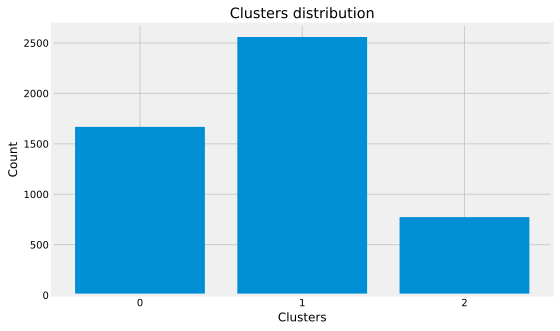

In [37]:
labels_clast_3_test = kmeans_3.predict(test.drop(['Id'], axis = 1))
labels_clast_3_test = pd.Series(labels_clast_3_test, name='clusters_3')

unique, counts = np.unique(labels_clast_3_test, return_counts=True)
display_clusters_distribution(unique, counts)

In [38]:
test_ext = pd.concat([test, labels_clast_3_test], axis=1)
test_ext.sort_values(by=['clusters_3', 'Id'], ascending=True, inplace=True)
test_ext

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecol_2_B,Ecol_3_B,Shops_2_B,clusters_3
4422,1,1,2.0,83.061098,59.709603,0.0,10,22.0,1977,0.007122,1,264,0,35.0,0,1,1,1,1,0
885,10014,1,1.0,38.796255,27.170354,1.0,8,17.0,1977,0.007122,1,264,0,35.0,0,1,1,1,1,0
4443,10040,62,2.0,66.296531,46.939302,1.0,8,8.0,1977,0.072158,2,629,1,0.0,0,0,1,1,0,0
1438,1005,124,2.0,74.408979,43.728861,4.0,8,40.0,2015,0.174739,17,3379,9,100.0,0,3,1,1,1,0
4252,10056,27,2.0,62.900094,45.216591,0.0,5,22.0,1977,0.211401,9,1892,0,370.0,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,9952,7,2.0,45.618487,29.896995,5.0,4,5.0,1967,0.130618,39,10418,9,900.0,1,9,1,1,1,2
486,9967,149,1.0,43.673970,20.564667,10.0,7,22.0,2006,0.041116,53,14892,4,1970.0,1,4,1,1,1,2
2310,9987,77,3.0,58.127454,36.212140,6.0,7,9.0,1974,0.000070,46,10309,1,240.0,1,16,1,1,1,2
2956,9989,2,3.0,78.582673,48.079375,10.0,10,12.0,2007,0.035145,42,9292,3,2620.0,0,3,1,1,1,2


             name     value
2          Square  0.403823
14        Shops_1  0.168561
9        Social_1  0.079962
10       Social_2  0.056595
11       Social_3  0.052366
0      DistrictId  0.042998
3      LifeSquare  0.035334
8       Ecology_1  0.034782
7       HouseYear  0.026632
5           Floor  0.022405
6      HouseFloor  0.018261
4   KitchenSquare  0.017646
12   Healthcare_1  0.015344
13    Helthcare_2  0.014752
1           Rooms  0.009100
17      Shops_2_B  0.001207
16       Ecol_3_B  0.000199
15       Ecol_2_B  0.000034
[0.8138115991893716, 0.8141217448021252, 0.8137181026606288, 0.8138882028642398, 0.8142144637152511, 0.8143134621721866, 0.8134692243549009, 0.8124032504660355, 0.8134272407493721, 0.8122835057187496, 0.8131310624724006]
Max valid R2 = 0.8143134621721866 ( train R2 = 0.9628150613193825 )
max_depth = 16


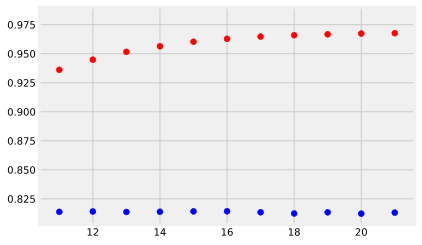

In [109]:
# Со всеми признаками
# rcParams['figure.figsize'] = 8, 7

X_train, X_test, y_train, y_test = train_test_split(train_ext[train_ext['clusters_3'] == 0].
                                                    drop(['Id', 'Price', 'clusters_3'], axis = 1), 
                                                    train_ext.loc[train_ext['clusters_3'] == 0, 'Price'], 
                                                    test_size = 0.2, random_state = 29)

r2_train = []
r2_test = []
max_depth = list(range(11, 22)) # 16
# n_estimators = list(range(257, 264)) # 260
for i in max_depth:
# for i in n_estimators:
    mod1 = RandomForestRegressor(max_depth=i, n_estimators=260, random_state = 29)
    mod1.fit(X_train,y_train)
    pr_train = mod1.predict(X_train)
    pr_test = mod1.predict(X_test)
    r2_train.append(r2(y_train, pr_train))
    r2_test.append(r2(y_test, pr_test))
    
imp = pd.DataFrame()
imp['name'] = X_train.columns
imp['value'] = mod1.feature_importances_
print(imp.sort_values('value', ascending = False))
print(r2_test)
print('Max valid R2 =', max(r2_test), '( train R2 =', r2_train[r2_test.index(max(r2_test))], ')')
print('max_depth =', max_depth[r2_test.index(max(r2_test))])
# print('n_estimators =', n_estimators[r2_test.index(max(r2_test))])
plt.scatter(max_depth, r2_train, c ='r')
plt.scatter(max_depth, r2_test, c = 'b')
# plt.scatter(n_estimators, r2_train, c ='r')
# plt.scatter(n_estimators, r2_test, c = 'b')
plt.grid(True)

             name     value
2          Square  0.525536
11       Social_3  0.061062
0      DistrictId  0.051133
4   KitchenSquare  0.044702
7       HouseYear  0.043619
8       Ecology_1  0.042164
3      LifeSquare  0.037570
6      HouseFloor  0.036727
12   Healthcare_1  0.036652
10       Social_2  0.029403
5           Floor  0.028522
14        Shops_1  0.018523
9        Social_1  0.015081
1           Rooms  0.014909
13    Helthcare_2  0.012262
16       Ecol_3_B  0.000836
17      Shops_2_B  0.000703
15       Ecol_2_B  0.000595
[0.6598622795971703, 0.6594009710352968, 0.6599114040566133, 0.6585193609755058, 0.6591128353920044, 0.658482502913798, 0.6604263868856173, 0.6602288993841496, 0.6579371700244159, 0.6593758067206932, 0.6606419100113579]
Max valid R2 = 0.6606419100113579 ( train R2 = 0.9581892799295977 )
max_depth = 21


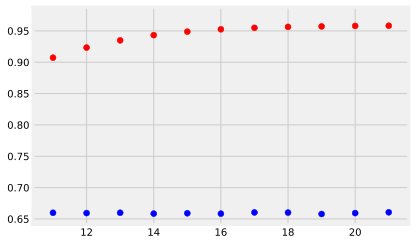

In [108]:
# Со всеми признаками
# rcParams['figure.figsize'] = 8, 7

X_train, X_test, y_train, y_test = train_test_split(train_ext[train_ext['clusters_3'] == 1].
                                                    drop(['Id', 'Price', 'clusters_3'], axis = 1), 
                                                    train_ext.loc[train_ext['clusters_3'] == 1, 'Price'], 
                                                    test_size = 0.2, random_state = 29)

r2_train = []
r2_test = []
max_depth = list(range(11, 22))
# n_estimators = list(range(444, 451)) # 447
for i in max_depth:
# for i in n_estimators:
    mod1 = RandomForestRegressor(max_depth=i, n_estimators=447, random_state = 29)
    mod1.fit(X_train,y_train)
    pr_train = mod1.predict(X_train)
    pr_test = mod1.predict(X_test)
    r2_train.append(r2(y_train, pr_train))
    r2_test.append(r2(y_test, pr_test))
    
imp = pd.DataFrame()
imp['name'] = X_train.columns
imp['value'] = mod1.feature_importances_
print(imp.sort_values('value', ascending = False))
print(r2_test)
print('Max valid R2 =', max(r2_test), '( train R2 =', r2_train[r2_test.index(max(r2_test))], ')')
print('max_depth =', max_depth[r2_test.index(max(r2_test))])
# print('n_estimators =', n_estimators[r2_test.index(max(r2_test))])
plt.scatter(max_depth, r2_train, c ='r')
plt.scatter(max_depth, r2_test, c = 'b')
# plt.scatter(n_estimators, r2_train, c ='r')
# plt.scatter(n_estimators, r2_test, c = 'b')
plt.grid(True)

             name     value
2          Square  0.648167
3      LifeSquare  0.079497
5           Floor  0.042370
7       HouseYear  0.036113
6      HouseFloor  0.030959
11       Social_3  0.028741
0      DistrictId  0.025837
12   Healthcare_1  0.022935
4   KitchenSquare  0.020648
10       Social_2  0.015824
14        Shops_1  0.015063
9        Social_1  0.014323
8       Ecology_1  0.009128
1           Rooms  0.007731
13    Helthcare_2  0.002148
17      Shops_2_B  0.000515
15       Ecol_2_B  0.000000
16       Ecol_3_B  0.000000
[0.6707037183392124, 0.6840279664323705, 0.6801782265022305, 0.6880605590657723, 0.6872919902610813, 0.6927083353785239, 0.6752574845415866, 0.6847226543596422, 0.6768147276161303, 0.6772286961054859, 0.6679306865870898]
Max valid R2 = 0.6927083353785239 ( train R2 = 0.933491906492762 )
max_depth = 16


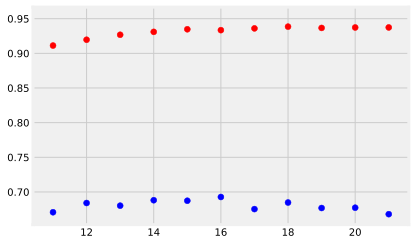

In [107]:
# Со всеми признаками
# rcParams['figure.figsize'] = 8, 7

X_train, X_test, y_train, y_test = train_test_split(train_ext[train_ext['clusters_3'] == 2].
                                                    drop(['Id', 'Price', 'clusters_3'], axis = 1), 
                                                    train_ext.loc[train_ext['clusters_3'] == 2, 'Price'], 
                                                    test_size = 0.2, random_state = 29)

r2_train = []
r2_test = []
max_depth = list(range(11, 22)) # 16
# n_estimators = list(range(13, 20)) # 16
for i in max_depth:
# for i in n_estimators:
    mod1 = RandomForestRegressor(max_depth=i, n_estimators=16, random_state = 29)
    mod1.fit(X_train,y_train)
    pr_train = mod1.predict(X_train)
    pr_test = mod1.predict(X_test)
    r2_train.append(r2(y_train, pr_train))
    r2_test.append(r2(y_test, pr_test))
    
imp = pd.DataFrame()
imp['name'] = X_train.columns
imp['value'] = mod1.feature_importances_
print(imp.sort_values('value', ascending = False))
print(r2_test)
print('Max valid R2 =', max(r2_test), '( train R2 =', r2_train[r2_test.index(max(r2_test))], ')')
print('max_depth =', max_depth[r2_test.index(max(r2_test))])
# print('n_estimators =', n_estimators[r2_test.index(max(r2_test))])
plt.scatter(max_depth, r2_train, c ='r')
plt.scatter(max_depth, r2_test, c = 'b')
# plt.scatter(n_estimators, r2_train, c ='r')
# plt.scatter(n_estimators, r2_test, c = 'b')
plt.grid(True)

### Обучение модели кластерно на всех данных и итоговое предсказание с найденными `best_params_`

In [ ]:
rgr_0 = RandomForestRegressor(max_depth=18, max_features=5, n_estimators=320, random_state=29)
rgr_0.fit(train_ext[train_ext['clusters_3'] == 0].drop(['Id', 'Price', 'clusters_3'], axis = 1) , 
          train_ext.loc[train_ext['clusters_3'] == 0, 'Price'])

In [ ]:
rgr_1 = RandomForestRegressor(max_depth=18, max_features=5, n_estimators=320, random_state=29)
rgr_1.fit(train_ext[train_ext['clusters_3'] == 1].drop(['Id', 'Price', 'clusters_3'], axis = 1) , 
          train_ext.loc[train_ext['clusters_3'] == 1, 'Price'])

In [ ]:
rgr_2 = RandomForestRegressor(max_depth=18, max_features=5, n_estimators=320, random_state=29)
rgr_2.fit(train_ext[train_ext['clusters_3'] == 2].drop(['Id', 'Price', 'clusters_3'], axis = 1) , 
          train_ext.loc[train_ext['clusters_3'] == 2, 'Price'])

#### Делаем предсказание

In [ ]:
itog_predict_rfr_CV_kmeans_full_model_c0 = rgr_0.predict(test_ext[(test_ext['clusters_3'] == 0)].drop(['Id', 'clusters_3'], axis = 1))

In [ ]:
itog_predict_rfr_CV_kmeans_full_model_c1 = rgr_1.predict(test_ext[(test_ext['clusters_3'] == 1)].drop(['Id', 'clusters_3'], axis = 1))

In [ ]:
itog_predict_rfr_CV_kmeans_full_model_c2 = rgr_2.predict(test_ext[(test_ext['clusters_3'] == 2)].drop(['Id', 'clusters_3'], axis = 1))

In [ ]:
itog_predict_rfr_CV_kmeans_cls_full_model = np.hstack([itog_predict_rfr_CV_kmeans_full_model_c0, 
                                                       itog_predict_rfr_CV_kmeans_full_model_c1, 
                                                       itog_predict_rfr_CV_kmeans_full_model_c2])

In [ ]:
test_ext['Price'] = itog_predict_rfr_CV_kmeans_cls_full_model

In [ ]:
test_ext[['Id', 'Price']].to_csv('rfr_CV_kmeans_cls_full_model_rev07.csv', index = False)

In [ ]:
imp = pd.DataFrame()
imp['name'] = test_ext.drop(['Id','Price', 'clusters_3'], axis = 1).columns
imp['value'] = rgr_0.feature_importances_
print(imp.sort_values('value' , ascending = False))

In [ ]:
imp = pd.DataFrame()
imp['name'] = test_ext.drop(['Id','Price', 'clusters_3'], axis = 1).columns
imp['value'] = rgr_1.feature_importances_
print(imp.sort_values('value' , ascending = False))

In [ ]:
imp = pd.DataFrame()
imp['name'] = test_ext.drop(['Id','Price', 'clusters_3'], axis = 1).columns
imp['value'] = rgr_2.feature_importances_
print(imp.sort_values('value' , ascending = False))

### Сохранение модели

**Scaler**

**Model**